<a href="https://colab.research.google.com/github/MissTiny/Graph_Mining_Node_Edge_K-Mean_Clustering/blob/main/GA_K_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports.

In [14]:
import json
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
import math

Reading Signed network.

In [5]:
signed_network = nx.read_weighted_edgelist('soc-sign-Slashdot090221.txt.gz', comments='#', create_using=nx.DiGraph(), nodetype = int)

Reading node features.

In [15]:
node_features ={}
no_of_features = 100
line_no = 0
with open("embedded-soc-sign-slashdot") as nf: 
    Lines = nf.readlines() 
    for line in Lines:
        #skip first line
        if line_no > 0:
            # splitting by space
            values = line.split()
            values = values[:no_of_features+1]
            index = 0
            # reading node features
            for val in values:
                if index == 0:
                    # reading nodeIds for first time
                    if line_no == 1:
                        node_features["nodeId"] = [int(val)]
                    else:
                        node_features["nodeId"].append(int(val))
                
                elif index > 0:
                    # reading features for the first time
                    if line_no == 1:
                        node_features["feature"+str(index)] = [float(val)]
                    else:
                        node_features["feature"+str(index)].append(float(val))
                index+=1
        line_no += 1

node_features_df = pd.DataFrame(node_features)

Determining optimal number of clusters or number of active centers using elbow method.

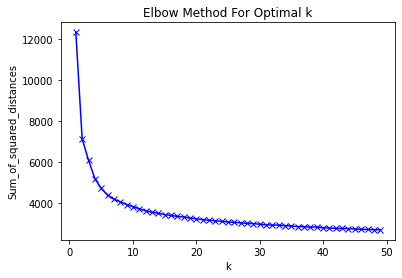

In [18]:
# To give equal importance to all features, we need to scale the continuous features. 
# We will be using scikit-learn’s MinMaxScaler as the feature matrix is a mix of binary and continuous features . 
mms = MinMaxScaler()
mms.fit(node_features_df)
node_features_df_transformed = mms.transform(node_features_df)

Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k, n_jobs=-1)
    km = km.fit(node_features_df_transformed)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above elbow plot, it looks like optimal value of K is 7.

In [17]:
K = 7

Extracting k active centers.

In [18]:
random.seed(0)
nodeIds = list(node_features_df["nodeId"])
active_centers = random.choices(nodeIds, k=K)

Removing active_centers.

In [19]:
# nodeIds Without active centers
nodeIdsWAC = list(set(nodeIds) - set(active_centers))

Calculating profile similarities.

In [25]:
# based on euclidean distance
def profSimilarity(nodeId, active_center):
    
    nodeId_index = nodeIds.index(nodeId)
    ac_index = active_centers.index(active_center)
    # setting to 1 to avoid division by zero error
    sum = 1
    for i in range(0, no_of_features):
        
        sq_diff = (node_features_df["feature"+str(i+1)][nodeId_index] - node_features_df["feature"+str(i+1)][ac_index])**2
        sum += sq_diff

    # returning inverse as high value means less similarity.
    return 1/math.sqrt(sum)

Social Circle Generation using K-means.

In [ ]:
# initializing social circles
social_circles = {}
for i in range (0, K):
        active_center = active_centers[i]
        social_circles[str(active_center)] = []

def edgeExists(nodeId, active_center):
    if signed_network.has_edge(nodeId, active_center):
        return 1
    else:
        return 0

def strengthOfTies(nodeId, active_center):
  sum = 0
  for degree in list(dict(signed_network.degree([nodeId, active_center])).values()):
    sum+=degree
  sum -= 1
  return 1/sum
  
for nodeId in nodeIdsWAC:
    maxPs = 0
    maxStr = 0
    
    for i in range (0, K):
        active_center = active_centers[i]
        p1 = 0
        p2 = 0
        p3 = 0
        
        p1 = edgeExists(nodeId, active_center)
        p2 = profSimilarity(nodeId, active_center)
        p3 = strengthOfTies(nodeId, active_center)

        if maxPs < p2:
          maxPs = p2
        else:
          maxPs = maxPs

        if maxStr < p3:
          maxStr = p3
        else:
          maxStr = maxStr

        for j in range (0, K):
          ac = active_centers[j]
          if p1 == 1 and p2 == maxPs and p3 == maxStr:
            social_circles[str(ac)].append(nodeId)

